# Replicating Maliar, Maliar, and Valli (2010, JEDC) to solve Krusell and Smith (1998, JPE) model using Julia

By [Shunsuke Hori](https://github.com/Shunsuke-Hori)


# Overview of the notebook
This notebook solves the model of Krusell and Smith (1998, JPE) and succesfully replicating the result of Maliar, Maliar, and Valli (2010, JEDC)

The solution strategy is as follows

1. Solve individual problem by Euler equation method with 2D interpolation
    - Agents are boundedly rational. In the code, they take into account the information about the mean of capital
    - Aggregate law of motion is approximated by log-linear relation, i.e. $\log(K_{t+1})=B1+B2\log(K_{t})$ for good aggregate state and $\log(K_{t+1})=B3+B4\log(K_{t})$ for bad aggregate state 
    - If specified, Howard's policy iteration is used
1. Compute the path of aggregate capital using the policy function obtained by VFI
    - Simulation is based on Monte Carlo. That is, aggregate technology shocks and idiosyncratic employment shocks are drawn for many agents and many periods. Then, using the LLN, the aggregate capital is computed by aggregating all agents for all period.
1. Update the coefficient of aggregate capital law of motion, $B1$, $B2$, $B3$ and $B4$, by regression
1. Check convergence of $B1$, $B2$, $B3$ and $B4$

Additionally, this notebook also includes the [result](http://localhost:8888/notebooks/KrusellSmith_Euler.ipynb#Implementation-with-value-function-iteration) with value function iteration as a solution method for individual utility maximization problem.

NOTE: Regarding interpolation, Krusell and Smith uses various interpolation scheme depending on the purpose, including polynomial interpolation. Maliar, Maliar, and Valli uses spline interpolation in their paper. This notebook only uses linear interpolation because I could not find interpolation package for polynomial and spline 2D-interpolation.



# Code to solve models

First thing to do is import some packages

In [1]:
using Interpolations # to use interpolation 
using QuantEcon  # to use a function, `gridmake`
using Plots      # to plot the result
pyplot()
#plotlyjs()
using Optim      # to use minimization routine to maximize RHS of bellman equation
using GLM        # to regress
using JLD        # to save the result

## Model Setup

Functions in this cell are prepared for model parameters and initial guess of the solutions 

- Types
    - `TransitionMatrix`: collection of transition matrix
    - `KSParameter`: collection of model parameters, functional forms, and grids
    - `KSSolution`: collection of solution, which is guess at first
- Methods
    - `create_transition_matrix`: construct an instance of type TransitionMatrix
    - `KSParameter`: construct an instance of type KSParameter 
    - `place_polynominal_grid`: create polynominal grid 
    - `r`: compute interest rate ( = marginal productivity of capital) 
    - `w`: compute wage rate ( = marginal productivity of labor)
    - `KSSolution`: construct an instance of type KSSolution
        - Guess can be the load of previous result

In [2]:
"""
Collection of transition matrix
"""
immutable TransitionMatrix
    P::Array{Float64,2}       # 4x4 
    Pz::Array{Float64,2}      # 2x2 aggregate shock
    Peps_gg::Array{Float64,2} # 2x2 idiosyncratic shock conditional on good to good
    Peps_bb::Array{Float64,2} # 2x2 idiosyncratic shock conditional on bad to bad
    Peps_gb::Array{Float64,2} # 2x2 idiosyncratic shock conditional on good to bad
    Peps_bg::Array{Float64,2} # 2x2 idiosyncratic shock conditional on bad to good
end

"""
Collection of model parameters
"""
immutable KSParameter
    u::Function
    beta::Float64
    alpha::Float64
    delta::Float64
    theta::Float64
    l_bar::Float64
    k_grid::Vector{Float64}
    K_grid::Vector{Float64}
    z_grid::Vector{Float64}
    eps_grid::Vector{Float64}
    s_grid::Array{Float64,2}
    k_size::Int64
    K_size::Int64
    z_size::Int64
    eps_size::Int64
    s_size::Int64
    ug::Float64
    ub::Float64
    TransMat::TransitionMatrix # bunch of transition matrix
    mu::Float64
end

""" 
Create transition matrices for aggregate shock,
idiosyncratic shock, and shock state

##### Arguments
- `ug` : unemployment rate in good state
- `ub` : unemployment rate in bad state
- `zg_ave_dur` : average duration of good state
- `zb_ave_dur` : average duration of bad state
- `ug_ave_dur` : average duration of unemployment in good state
- `ub_ave_dur` : average duration of unemployment in bad state
- `puu_rel_gb2bb` : prob. of u to u cond. on g to b relative to that of b to b 
- `puu_rel_bg2gg` : prob. of u to u cond. on b to g relative to that of g to g
"""
function create_transition_matrix(ug::Float64,ub::Float64,
        zg_ave_dur::Float64,zb_ave_dur::Float64,
        ug_ave_dur::Float64,ub_ave_dur::Float64,
        puu_rel_gb2bb::Float64,puu_rel_bg2gg::Float64)
    
    # probability of remaining in good state
    pgg = 1-1/zg_ave_dur
    # probability of remaining in bad state
    pbb = 1-1/zb_ave_dur
    # probability of changing from g to b
    pgb = 1-pgg
    # probability of changing from b to g
    pbg = 1-pbb  
    
    # prob. of 0 to 0 cond. on g to g
    p00_gg = 1-1/ug_ave_dur
    # prob. of 0 to 0 cond. on b to b
    p00_bb = 1-1/ub_ave_dur
    # prob. of 0 to 1 cond. on g to g
    p01_gg = 1-p00_gg
    # prob. of 0 to 1 cond. on b to b
    p01_bb = 1-p00_bb
    
    # prob. of 0 to 0 cond. on g to b
    p00_gb=puu_rel_gb2bb*p00_bb
    # prob. of 0 to 0 cond. on b to g
    p00_bg=puu_rel_bg2gg*p00_gg
    # prob. of 0 to 1 cond. on g to b
    p01_gb=1-p00_gb
    # prob. of 0 to 1 cond. on b to g
    p01_bg=1-p00_bg
    
    # prob. of 1 to 0 cond. on  g to g
    p10_gg=(ug - ug*p00_gg)/(1-ug)
    # prob. of 1 to 0 cond. on b to b
    p10_bb=(ub - ub*p00_bb)/(1-ub)
    # prob. of 1 to 0 cond. on g to b
    p10_gb=(ub - ug*p00_gb)/(1-ug)
    # prob. of 1 to 0 cond on b to g
    p10_bg=(ug - ub*p00_bg)/(1-ub)
    # prob. of 1 to 1 cond. on  g to g
    p11_gg= 1-p10_gg
    # prob. of 1 to 1 cond. on b to b
    p11_bb= 1-p10_bb
    # prob. of 1 to 1 cond. on g to b
    p11_gb= 1-p10_gb
    # prob. of 1 to 1 cond on b to g
    p11_bg= 1-p10_bg
    
    #   (g1)         (b1)        (g0)       (b0)
    P=[pgg*p11_gg pgb*p11_gb pgg*p10_gg pgb*p10_gb;
        pbg*p11_bg pbb*p11_bb pbg*p10_bg pbb*p10_bb;
        pgg*p01_gg pgb*p01_gb pgg*p00_gg pgb*p00_gb;
        pbg*p01_bg pbb*p01_bb pbg*p00_bg pbb*p00_bb
        ]
    Pz=[pgg pgb;
        pbg pbb]
    Peps_gg=[p11_gg p10_gg
              p01_gg p00_gg]
    Peps_bb=[p11_bb p10_bb
              p01_bb p00_bb]
    Peps_gb=[p11_gb p10_gb
              p01_gb p00_gb]
    Peps_bg=[p11_bg p10_bg
              p01_bg p00_bg]
    TransMat=TransitionMatrix(P,Pz,Peps_gg,Peps_bb,Peps_gb,Peps_bg)
    return TransMat
end

"""
Creates KSParameter instance
"""
function KSParameter(;
            beta::Float64=0.99,
            alpha::Float64=0.36,
            delta::Float64=0.025,
            theta::Float64=1.0,
            k_min::Float64=1e-16,
            k_max::Float64=1000.0,
            k_size::Int64=100,
            K_min::Float64=30.0,
            K_max::Float64=50.0,
            K_size::Int64=4,
            z_min::Float64=0.99,
            z_max::Float64=1.01,
            z_size::Int64=2,
            eps_min::Float64=0.0,
            eps_max::Float64=1.0,
            eps_size::Int64=2,
            ug::Float64=0.04,
            ub::Float64=0.1,
            zg_ave_dur::Float64=8.0,
            zb_ave_dur::Float64=8.0,
            ug_ave_dur::Float64=1.5,
            ub_ave_dur::Float64=2.5,
            puu_rel_gb2bb::Float64=1.25,
            puu_rel_bg2gg::Float64=0.75,
            mu::Float64=0.0
            )
    if theta == 1.0
        u = (c) -> log(c)
    else
        u = (c) -> (c^(1.0-theta)-1.0)/(1.0-theta)
    end
    l_bar=1/(1-ub)
    k_grid=place_polynominal_grid(k_min,k_max,k_size,degree=7.0)   # individual capital grid
    K_grid=collect(linspace(K_min,K_max,K_size))   # aggregate capital grid
    z_grid=collect(linspace(z_max,z_min,z_size))   # aggregate technology shock
    eps_grid=collect(linspace(eps_max,eps_min,eps_size))  # idiosyncratic employment shock
    s_grid=gridmake(z_grid,eps_grid)               # shock grid
    # collection of transition matrices
    TransMat=create_transition_matrix(ug,ub,
        zg_ave_dur,zb_ave_dur,
        ug_ave_dur,ub_ave_dur,
        puu_rel_gb2bb,puu_rel_bg2gg)

    ksp=KSParameter(u,beta,alpha,delta,theta,l_bar,k_grid,K_grid,z_grid,eps_grid,s_grid,
    k_size,K_size,z_size,eps_size,z_size*eps_size,ug,ub,TransMat,mu)

    return ksp
end

function place_polynominal_grid(k_min::Float64,k_max::Float64,k_size::Int64;degree::Float64=0.7)
    grid=Array{Float64}(k_size)
    for (i, x) in enumerate(linspace(0,0.5,k_size))
        grid[i]=(x/0.5)^degree*(k_max-k_min)+k_min
    end
    return grid
end
"""
Compute interest rate given aggregate capital, labor, and productivity

##### Arguments
- `alpha` : capital share
- `z` : aggregate shock
- `K` : aggregate capital
- `L` : aggregate labor
"""
r(alpha::Float64,z::Float64,K::Float64,L::Float64)=alpha*z*K^(alpha-1)*L^(1-alpha)

"""
Compute wage given aggregate capital, labor, and productivity

##### Arguments
- `alpha` : capital share
- `z` : aggregate shock
- `K` : aggregate capital
- `L` : aggregate labor
"""
w(alpha::Float64,z::Float64,K::Float64,L::Float64)=(1-alpha)*z*K^(alpha)*L^(-alpha)    

"""
Collection of KS solution
"""
type KSSolution
    k_opt::Array{Float64,3}
    value::Array{Float64,3}
    B::Vector{Float64}
    R2::Vector{Float64}
end

"""
Create KSSolution instance
"""
function KSSolution(
        ksp::KSParameter;
        load_value::Bool=false,
        load_B::Bool=false,
        filename::String="result.jld")
    if load_value || load_B
        result=load(filename)
        kss_temp=result["kss"]
    end
    if load_value
        k_opt=kss_temp.k_opt
        value=kss_temp.value
    else
        k_opt=ksp.beta*repeat(ksp.k_grid,outer=[1,ksp.K_size,ksp.s_size])
        k_opt=0.9*repeat(ksp.k_grid,outer=[1,ksp.K_size,ksp.s_size])
        value=ksp.u.(0.1/0.9*k_opt)/(1-ksp.beta)
    end
    if load_B
        B=kss_temp.B
    else
        B=[0.0, 1.0, 0.0, 1.0]
    end
    kss=KSSolution(k_opt,value,B,[0.0,0.0])
    return kss
end


KSSolution

## Shock Generation
The functions in this cell are used to draw aggregate and idiosyncratic shocks
- Methods
    - `get_shock`: translate an index shock combination grid to shock value
    - `generate_shocks`: draw aggregate and idiosyncratic shocks, which is the main function in this cell
        - `draw_eps_shock` (local function inside `generate_shocks`): draw idiosyncratic shocks given aggregate shocks

In [3]:

""" 
Translate shock index into shock value

##### Arguments
- `s_grid` : shock  grid
- `s_i` : shock index
"""
get_shock(s_grid::Array{Float64,2},s_i::Integer) = 
    s_grid[s_i,1], s_grid[s_i,2] 

"""
Generate aggregate and idiosyncratic shock

##### Arguments
- `ksp` : instance of KSParameter type
- `z_shock_size` : size of aggregate shock
- `population` : size idiosyncratic shock in one period
"""
function generate_shocks(ksp::KSParameter;
        z_shock_size::Int64=11000,population::Int64=10000)
    
    
    """ 
    Draw idiosyncratic shock given previous idiosyncratic shock and 
    transition matrix.
    The transition matrix must be consistent with aggregate shock

    ##### Arguments
    - `eps_shock` : preallocated vector. current period shock is stored in it
    - `eps_shock_before` : previous period idiosyncratic shock
    - `Peps` : transition matrix of the current period
    """
    function draw_eps_shock(eps_shock_before::Vector{Float64},
                              Peps::Array{Float64,2})
    
        eps_shocks = similar(eps_shock_before)
        # loop over entire population
        for i=1:length(eps_shocks)
            rand_draw=rand()
            eps_shocks[i]=ifelse(eps_shock_before[i]==1.0,
                Float64(Peps[1,1]>rand_draw),  # if employed before
                Float64(Peps[2,1]>rand_draw))  # if unemployed before
        end
        return eps_shocks
    end
    
    # unpack parameters
    Peps_gg=ksp.TransMat.Peps_gg
    Peps_bg=ksp.TransMat.Peps_bg
    Peps_gb=ksp.TransMat.Peps_gb
    Peps_bb=ksp.TransMat.Peps_bb
    
    # draw aggregate shock
    z_shock=simulate(MarkovChain(ksp.TransMat.Pz,ksp.z_grid),z_shock_size)
    
    ### Let's draw individual shock ###
    eps_shock=Array{Float64}(z_shock_size,population) # preallocation
    
    # first period
    rand_draw=rand(population)
    if z_shock[1]==ksp.z_grid[1] # if good
        eps_shock[1,:].=Int64.(rand_draw.>ksp.ug) # if draw is higher, become employed
    elseif z_shock[1]==ksp.z_grid[2] # if bad
        eps_shock[1,:].=Int64.(rand_draw.>ksp.ub) # if draw is higher, become employed
    else
        error("the value of z_shock[1] (=$(z_shock[1])) is strange")
    end
    
    # from second period ...
    for t=2:z_shock_size
        if z_shock[t]==ksp.z_grid[1] && z_shock[t-1]==ksp.z_grid[1]  # if g to g
            eps_shock[t,:]=draw_eps_shock(eps_shock[t-1,:],Peps_gg)
        elseif z_shock[t]==ksp.z_grid[1] && z_shock[t-1]==ksp.z_grid[2]  # if b to g
            eps_shock[t,:]=draw_eps_shock(eps_shock[t-1,:],Peps_bg)
        elseif z_shock[t]==ksp.z_grid[2] && z_shock[t-1]==ksp.z_grid[1]  # if g to b
            eps_shock[t,:]=draw_eps_shock(eps_shock[t-1,:],Peps_gb)
        elseif z_shock[t]==ksp.z_grid[2] && z_shock[t-1]==ksp.z_grid[2]  # if b to b
            eps_shock[t,:]=draw_eps_shock(eps_shock[t-1,:],Peps_bb)
        else
            error("the value of z_shock[t] (=$(z_shock[t])) is strange")
        end
    end
    
    # adjustment
    for t=1:z_shock_size
        n_e=Int64(sum(eps_shock[t,:]))
        er_ideal = ifelse(z_shock[t] == ksp.z_grid[1],
                    1.0-ksp.ug, 1.0-ksp.ub)
        gap = Int64(round(er_ideal*population)) - n_e
        if gap > 0
            for j=1:gap
                become_employed_i = 
                    sample(find(x-> isapprox(x,ksp.eps_grid[2]), eps_shock[t,:]))
                eps_shock[t,become_employed_i] = ksp.eps_grid[1]
            end
        elseif gap < 0
            for j=1:(-gap)
                become_unemployed_i = 
                    sample(find(x-> isapprox(x,ksp.eps_grid[1]), eps_shock[t,:]))
                eps_shock[t,become_unemployed_i] = ksp.eps_grid[2]
            end
        end 
    end
            
    return z_shock, eps_shock    
end



generate_shocks

## Functions for Euler equation method

Functions in this cell is used to solve individual problem by Euler equation method

- Methods
    - compute_Kp_L: compute approximated $K'$ and $L$, which depend on current aggregate shock
    - compute_expectation_FOC: compute expectation term in Euler equation
    - euler_method!: find optimal policy by Euler equation methods, namely, iteration of Euler equation
    
    $$ \left(c\right)^{-\theta}=\beta E\left[\left(c'\right)^{-\theta}(1-\delta+r')\right] $$

In [4]:
"""
Compute next period aggregate capital and labor

##### Arguments
- `K` : Current aggregate capital
- `s_i` : current shock index
- `B` : coefficient of ALM for capital
"""
function compute_Kp_L(K::AbstractFloat,s_i::Integer,B::Vector{Float64},ksp::KSParameter)
    Kp,L=ifelse(ksp.s_grid[s_i,1]==ksp.z_grid[1],
            (exp(B[1]+B[2]*log(K)),ksp.l_bar*(1-ksp.ug)),
            (exp(B[3]+B[4]*log(K)),ksp.l_bar*(1-ksp.ub)))
    Kp = ifelse(Kp<ksp.K_grid[1],ksp.K_grid[1],Kp)
    Kp = ifelse(Kp>ksp.K_grid[end],ksp.K_grid[end],Kp)
    return Kp, L
end

"""
Compute expectation term in Euler equation

##### Arguments
- `kp` : next period individual capital holding
- `Kp` : next period aggregate capital
- `s_i` : current state of shock
- `ksp` : KSParameter instance
"""
function compute_expectation_FOC(kp::Float64,
                                  Kp::Float64,
                                  s_i::Int64,
                                  ksp::KSParameter)
    alpha, theta, delta, l_bar, mu, P =
        ksp.alpha, ksp.theta, ksp.delta, ksp.l_bar, ksp.mu, ksp.TransMat.P
    expec = 0.0
    for s_n_i = 1:ksp.s_size
        zp, epsp = ksp.s_grid[s_n_i,1], ksp.s_grid[s_n_i,2]
        Kpp, Lp = compute_Kp_L(Kp,s_n_i,kss.B,ksp)
        rn=r(alpha,zp,Kp,Lp)
        kpp=interpolate((ksp.k_grid,ksp.K_grid),
                kss.k_opt[:,:,s_n_i],Gridded(Linear()))
        cp = (rn+1-delta)*kp+
                   w(alpha,zp,Kp,Lp)*(epsp*l_bar+mu*(1.0-epsp))-kpp[kp,Kp]
        expec = expec + P[s_i,s_n_i]*(cp)^(-theta)*(1-delta+rn)
    end 
    return expec
end

"""
Solve individual problem by Euler equation method

##### Arguments
- `ksp` : KSParameter instance
- `kss` : KSSolution instance
- `n_iter` : maximum number of iteration of Euler equation method
- `tol` : tolerance of policy function convergence
- `update_k` : degree of update of policy function
"""
function euler_method!(ksp::KSParameter,
                        kss::KSSolution;
                        n_iter::Integer=30000,
                        tol::AbstractFloat=1e-8,
                        update_k::AbstractFloat=1e-8)
    println("solving individual problem by Euler equation method")
    alpha, beta, delta, theta, l_bar, mu = 
        ksp.alpha, ksp.beta, ksp.delta, ksp.theta, ksp.l_bar, ksp.mu
    k_grid, k_size = ksp.k_grid, ksp.k_size
    K_grid, K_size = ksp.K_grid, ksp.K_size
    s_grid, s_size = ksp.s_grid, ksp.s_size
    k_min, k_max = minimum(k_grid), maximum(k_grid)
    counter=0
    k_opt_n=similar(kss.k_opt)
    while true
        counter += 1
        dif_k=0.0
        for s_i = 1:s_size
            z, eps = s_grid[s_i,1], s_grid[s_i,2]
            for K_i = 1:K_size
                K = K_grid[K_i]
                Kp, L = compute_Kp_L(K,s_i,kss.B,ksp)
                for k_i = 1:k_size
                    k=k_grid[k_i]
                    wealth = (r(alpha,z,K,L)+1-delta)*k+
                                w(alpha,z,K,L)*(eps*l_bar+mu*(1.0-eps))
                    expec=compute_expectation_FOC(kss.k_opt[k_i,K_i,s_i],Kp,s_i,ksp)
                    cn=(beta*expec)^(-1.0/theta)
                    k_opt_n[k_i,K_i,s_i] = wealth-cn
                    k_opt_n[k_i,K_i,s_i] = ifelse(k_opt_n[k_i,K_i,s_i]>k_max,k_max,k_opt_n[k_i,K_i,s_i])
                    k_opt_n[k_i,K_i,s_i] = ifelse(k_opt_n[k_i,K_i,s_i]<k_min,k_min,k_opt_n[k_i,K_i,s_i])
                    
                end
            end
        end
        dif_k=maxabs(k_opt_n-kss.k_opt)
        kss.k_opt.=update_k.*k_opt_n.+(1-update_k).*kss.k_opt
        if dif_k<tol
            println("Euler method converged with $counter iterations")
            break
        end
        if counter >=n_iter
            println("Euler method failed to converge with $counter iterations (dif = $dif_k)")
            break
        end
    end
end

euler_method!

## Simulate path of aggregate capital
- Mathods
    - simulate_aggregate_path!: simulating aggregate path of capital using shocks drawn

In [5]:
"""
Simulate aggregate capital's path using policy function 
and generated aggregate and idiosyncratic shock

##### Arguments
- `ksp` : KSParameter instance
- `z_shocks` : aggregate shocks
- `eps_shocks` : idiosyncratic shocks
- `k_population` : initial capital holding of all agents
"""
function simulate_aggregate_path!(ksp::KSParameter,kss::KSSolution,
        z_shocks::Vector{Float64},eps_shocks::Array{Float64,2},
        k_population::Vector{Float64},K_ts::Vector{Float64})
    
    println("simulating aggregate path ... please wait ... ")
    
    T=length(z_shocks)   # simulated duration
    N=size(eps_shocks,2) # number of agents
    
    
    # loop over T periods
    for (t,z) = enumerate(z_shocks)
        K_ts[t]=mean(k_population) # current aggrgate capital
        
        # s_i_base takes 1 when good and 2 when bad 
        s_i_base=ifelse(z==ksp.z_grid[1],1,2)        
        
        # loop over individuals
        for (i,k) in enumerate(k_population)
            eps = eps_shocks[t,i]   # idiosyncratic shock
            s_i=s_i_base+2*(1-Int64(eps))  # transform (z,eps) to s_i
            # obtain next capital holding by interpolation
            
            itp_pol=interpolate((ksp.k_grid,ksp.K_grid),kss.k_opt[:,:,s_i],Gridded(Linear()))
            k_population[i]=itp_pol[k,K_ts[t]]
        end
    end
    
    return nothing
end


simulate_aggregate_path!

## Obtaining aggregate law of motion coefficient

The functions in this cell are used to obtain the coefficient of approximate aggregate capital law of motion (ALM)

- Methods
    - regress_ALM: regress aggregate capital law of motion and obtain approximate ALM
    - find_ALM_coef!: main iteration. update ALM coefficient until convergence

In [6]:
"""
Obtain new aggregate law of motion coefficients 
using the aggregate capital flaw

##### Arguments
- `ksp` : KSParameter instance
- `z_shock` : aggregate shocks
- `K_ts` : aggregate capital flaw
- `n_discard` : number of discarded samples
"""
function regress_ALM!(ksp::KSParameter,kss::KSSolution,
                        z_shock::Vector{Float64},K_ts::Vector{Float64};
                        n_discard::Int64=100)
    z_grid=ksp.z_grid
    n_g=count(i->(i==z_grid[1]),z_shocks[n_discard+1:end-1])
    n_b=count(i->(i==z_grid[2]),z_shocks[n_discard+1:end-1])
    B_n=Vector{Float64}(4)
    x_g=Vector{Float64}(n_g)
    y_g=Vector{Float64}(n_g)
    x_b=Vector{Float64}(n_b)
    y_b=Vector{Float64}(n_b)
    i_g=0
    i_b=0
    for t = n_discard+1:length(z_shocks)-1
        if z_shocks[t]==z_grid[1]
            i_g=i_g+1
            x_g[i_g]=log(K_ts[t])
            y_g[i_g]=log(K_ts[t+1])
        else
            i_b=i_b+1
            x_b[i_b]=log(K_ts[t])
            y_b[i_b]=log(K_ts[t+1])
        end
    end
    resg=lm(hcat(ones(n_g,1),x_g),y_g)
    resb=lm(hcat(ones(n_b,1),x_b),y_b)
    kss.R2=[r2(resg),r2(resb)]
    B_n[1],B_n[2]=coef(resg)
    B_n[3],B_n[4]=coef(resb)
    dif_B=maximum(abs(B_n-kss.B))
    println("difference of ALM coefficient is $dif_B and B = $B_n")
    return B_n, dif_B
end

function find_ALM_coef!(
                       ksp::KSParameter,
                       kss::KSSolution,
                       z_shocks::Vector{Float64},
                       eps_shocks::Array{Float64,2};
                       tol_ump::AbstractFloat=1e-8,
                       max_iter_ump::Integer=100,
                       Howard_on::Bool=true,
                       Howard_n_iter::Integer=20,
                       tol_B::AbstractFloat=1e-8,
                       max_iter_B::Integer=20,
                       update_B::AbstractFloat=0.3,
                       T_discard::Integer=100,
                       print_skip_VFI::Integer=10,
                       method::Symbol=:Euler,
                       update_k::AbstractFloat=0.3)

    K_ts=similar(z_shocks)
    # populate initial capital holdings
    k_population=37.9893*ones(size(eps_shocks,2))
    counter_B=0
    while true
        counter_B=counter_B+1
        println(" --- Iteration over ALM coefficient: $counter_B ---")

        # solve individual problem
        if method == :VFI
            solve_bellman!(ksp,kss,
                           tol=tol_ump,
                           max_iter=max_iter_ump,
                           Howard=Howard_on,
                           Howard_n_iter=Howard_n_iter,
                           print_skip=print_skip_VFI)
        elseif method == :Euler
            euler_method!(ksp,kss,
                        n_iter=max_iter_ump,
                        tol=tol_ump,
                        update_k=update_k)
        end
        

        # compute aggregate path of capital
        simulate_aggregate_path!(ksp,kss,z_shocks,eps_shocks,k_population,K_ts)
        
        # obtain new ALM coefficient by regression
        B_n,dif_B = regress_ALM!(ksp,kss,z_shocks,K_ts,n_discard=T_discard)

        # check convergence
        if dif_B < tol_B
            println("-----------------------------------------------------")
            println("ALM coefficient successfully converged : dif = $dif_B")
            println("-----------------------------------------------------")
            kss.B .= update_B .* B_n .+ (1-update_B) .* kss.B
            break
        elseif counter_B == max_iter_B
            println("----------------------------------------------------------------")
            println("Iteration over ALM coefficient reached its maximum ($max_iter_B)")
            println("----------------------------------------------------------------")
            kss.B .= update_B .* B_n .+ (1-update_B) .* kss.B
            break
        end
        
        # Update B
        kss.B .= update_B .* B_n .+ (1-update_B) .* kss.B
    end
    return K_ts
end


find_ALM_coef! (generic function with 1 method)

## Plotting
The function is used to plot the path of true path of aggregate capital and approximated one
- Methods
    - plot_ALM: plot the path of true path of aggregate capital and approximated one

In [7]:
"""
Plot true and approximated ALM of capital 

##### Arguments
- `ksp.z_grid` : aggregate shock grid
- `z_shocks` : aggregate shock
- `kss.B` : ALM coefficient
- `K_ts` : actual path of capital
"""
function plot_ALM(z_grid::Vector{Float64},
                  z_shocks::Vector{Float64},
                  B::Vector{Float64},
                  K_ts::Vector{Float64};
                  T_discard=1000)

    K_ts_approx = similar(K_ts) # preallocation

    # compute approximate ALM for capital
    K_ts_approx[T_discard]=K_ts[T_discard]

    for t=T_discard:length(z_shocks)-1
        if z_shocks[t] == z_grid[1]
            K_ts_approx[t+1]=exp(B[1]+B[2]*log(K_ts_approx[t]))
        elseif z_shocks[t] == z_grid[2]
            K_ts_approx[t+1]=exp(B[3]+B[4]*log(K_ts_approx[t]))
        end
    end

    plot(T_discard+1:length(K_ts),K_ts[T_discard+1:end],lab="true",color=:red,line=:solid)
    plot!(T_discard+1:length(K_ts),K_ts_approx[T_discard+1:end],lab="approximation",color=:blue,line=:dash)
    title!("aggregate law of motion for capital")
    
end

plot_ALM

## Implementation by Euler method

First, construct model instance `ksp` and initial guess of the solution inside `kss` 

(Grid size inconsistency is also checked, which may return error when exiting result is loaded by `load_value=true`)

In [8]:
# instance of KSParameter
ksp=KSParameter(k_size=100,
                k_min=1e-16)
# instance of KSSolution
kss=KSSolution(ksp,load_value=false,load_B=false)
if size(kss.k_opt,1) != length(ksp.k_grid)
    error("loaded data is inconsistent with k_size")
end
if size(kss.k_opt,2) != length(ksp.K_grid)
    error("loaded data is inconsistent with K_size")
end

Let's draw the shock for stochastic simulation of aggregate law of motion

In [9]:
# generate shocks
srand(123)
z_shocks,eps_shocks =generate_shocks(ksp;
        z_shock_size=11000,population=5000);

Now, the following cell solves the model with Euler equation method

In [10]:
# find ALM coefficient
@time K_ts = find_ALM_coef!(ksp,kss,z_shocks,eps_shocks,
               tol_ump=1e-8,max_iter_ump=10000,
               Howard_on=true,Howard_n_iter=20,
               tol_B=1e-8, max_iter_B=50,update_B=0.3,
               T_discard=1000,print_skip_VFI=10,
               method=:Euler, update_k=0.7);

 --- Iteration over ALM coefficient: 1 ---
solving individual problem by Euler equation method
Euler method converged with 1868 iterations
simulating aggregate path ... please wait ... 
difference of ALM coefficient is 0.4556643772779668 and B = [0.455664,0.877296,0.438162,0.880418]
 --- Iteration over ALM coefficient: 2 ---
solving individual problem by Euler equation method
Euler method converged with 2005 iterations
simulating aggregate path ... please wait ... 
difference of ALM coefficient is 0.01194706494540887 and B = [0.137682,0.963462,0.119502,0.96685]
 --- Iteration over ALM coefficient: 3 ---
solving individual problem by Euler equation method
Euler method converged with 1479 iterations
simulating aggregate path ... please wait ... 
difference of ALM coefficient is 0.012429438071340365 and B = [0.149423,0.960332,0.135204,0.962694]
 --- Iteration over ALM coefficient: 4 ---
solving individual problem by Euler equation method
Euler method converged with 1516 iterations
simulat

Euler method converged with 37 iterations
simulating aggregate path ... please wait ... 
difference of ALM coefficient is 1.5634870192959838e-7 and B = [0.145948,0.961181,0.132058,0.963525]
 --- Iteration over ALM coefficient: 31 ---
solving individual problem by Euler equation method
Euler method converged with 27 iterations
simulating aggregate path ... please wait ... 
difference of ALM coefficient is 1.0716623247142287e-7 and B = [0.145948,0.961181,0.132058,0.963525]
 --- Iteration over ALM coefficient: 32 ---
solving individual problem by Euler equation method
Euler method converged with 20 iterations
simulating aggregate path ... please wait ... 
difference of ALM coefficient is 7.337721727451729e-8 and B = [0.145948,0.961181,0.132058,0.963525]
 --- Iteration over ALM coefficient: 33 ---
solving individual problem by Euler equation method
Euler method converged with 18 iterations
simulating aggregate path ... please wait ... 
difference of ALM coefficient is 5.00449526541491e-8 a

Let's compare the true aggreate law of motion for capital and approximated one with figure and regression


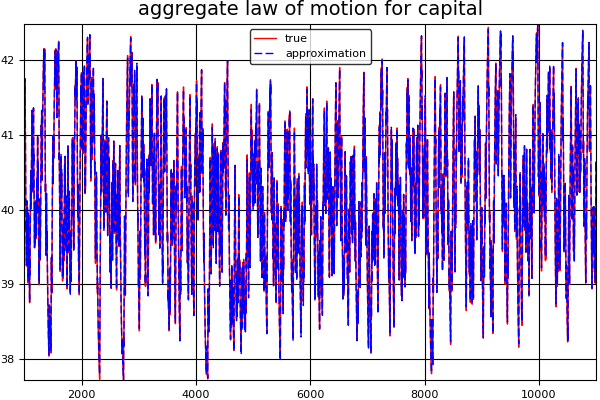

In [11]:
plot_ALM(ksp.z_grid,z_shocks,
         kss.B,K_ts)

In [12]:
#kss.B  # Regression coefficient
println("Approximated aggregate capital law of motion")
println("log(K_{t+1})=$(kss.B[1])+$(kss.B[2])log(K_{t}) in good time (R2 = $(kss.R2[1]))")
println("log(K_{t+1})=$(kss.B[3])+$(kss.B[4])log(K_{t}) in bad time (R2 = $(kss.R2[2]))")

Approximated aggregate capital law of motion
log(K_{t+1})=0.14594821741362846+0.9611811624862514log(K_{t}) in good time (R2 = 0.9999988558436316)
log(K_{t+1})=0.13205800455894173+0.9635249205659238log(K_{t}) in bad time (R2 = 0.9999972131809477)


The approximated law of motion of capital is very close to the true one, which implies that assuming agents are partially rational is not bad idea since the difference of their actions are negligible.

Note: The mean of capital, about 40, is  sufficiently close to Maliar, Maliar, Valli but higher than Krusell-Smith.

In [13]:
save("result_Euler.jld","kss",kss)

In [14]:
# Compute mean of capital implied by regression
mc=MarkovChain(ksp.TransMat.Pz)
sd=stationary_distributions(mc)[1]
logKg=kss.B[1]/(1-kss.B[2])
logKb=kss.B[3]/(1-kss.B[4])
meanK_reg=exp(sd[1]*logKg+sd[2]*logKb)
meanK_sim=mean(K_ts[1001:end])
println("mean of capital implied by regression is $meanK_reg")
println("mean of capital implied by simulation is $meanK_sim")

mean of capital implied by regression is 40.049373762168585
mean of capital implied by simulation is 40.160799927814296


## Figures in Krusell-Smith

Let's prepare some functions for figures in Krusell-Smith

In [15]:
function plot_Fig1(ksp,kss,K_ts)
    B=kss.B
    K_min, K_max = minimum(K_ts), maximum(K_ts)
    K_lim=collect(linspace(K_min,K_max,100))
    Kp_g=exp(B[1]+B[2]*log(K_lim))
    Kp_b=exp(B[3]+B[4]*log(K_lim))
    
    p=plot(K_lim,Kp_g,linestyle=:solid,lab="Good")
    plot!(p,K_lim,Kp_b,linestyle=:solid,lab="Bad")
    plot!(p,K_lim,K_lim,color=:black,linestyle=:dash,lab="45 degree",width=0.5)
    title!(p,"FIG1: Tomorrow's vs. today's aggregate capital")
    p
end

function plot_Fig2(ksp,kss,K_eval_point)
    k_lim=collect(linspace(0,80,1000))
    itp_e=interpolate((ksp.k_grid,ksp.K_grid),kss.k_opt[:,:,1],Gridded(Linear()))
    itp_u=interpolate((ksp.k_grid,ksp.K_grid),kss.k_opt[:,:,3],Gridded(Linear()))
    
    kp_e(k)=itp_e[k,K_eval_point]
    kp_u(k)=itp_u[k,K_eval_point]
    
    p=plot(k_lim,kp_e.(k_lim),linestyle=:solid,lab="employed")
    plot!(p,k_lim,kp_u.(k_lim),linestyle=:solid,lab="unemployed")
    plot!(p,k_lim,k_lim,color=:black,linestyle=:dash,lab="45 degree",width=0.5)
    title!(p,"FIG2: Individual policy function \n at K=$K_eval_point when good state")
    p
end

plot_Fig2 (generic function with 1 method)

Now, plot the replication figure:

### Figure 1


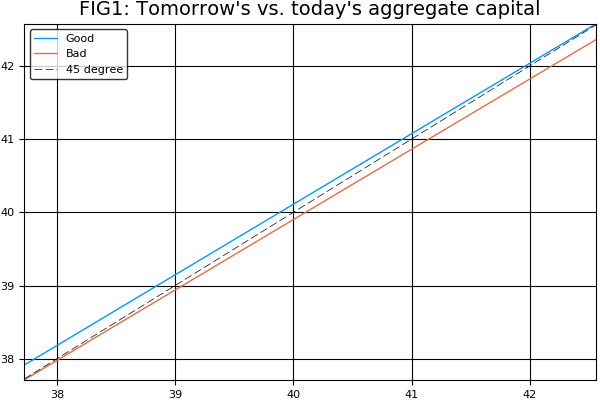

In [16]:
plot_Fig1(ksp,kss,K_ts)

### Figure 2


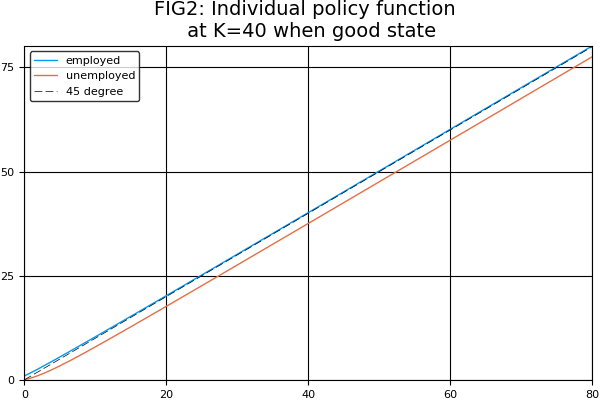

In [17]:
plot_Fig2(ksp,kss,40)

Both figures are replicated well. 

Note that the mean of capital is approximately 40 in this replication, which is different from Krusell-Smith but same as Maliar, Maliar, Valli. Therefore, Figure 1 is plotted around 40 and policy function for Figure 2 is evaluated at K=40

# Solution with value function iteration
In this section, each agent's utility maximization problem is solved by value function iteration.

Let's prepare functions for value function iteration
## Bellman equation and VFI
The functions in this cell are used to solve individual household problem by VFI
- Methods
    - rhs_bellman: evaluate RHS of bellman equation given the guess of value function
    - compute_expectation_VFI: compute expectation term of Bellman equation given current shock state
    - solve_bellman_once!: maximize RHS of Bellman equation for an agent of state (k_i,K_i,s_i)
    - solve_bellman!: maximize RHS of Bellman equation for all state until convergence
    - iterate_policy!: iterating policy and compute values under the policy. used for Howard

In [18]:
"""
Compute right hand side of bellman equation

##### Arguments
- `kp` : next period capital
- `ksm` : KSModel instance
- `k` : current individual capital
- `K` : current aggregate capital
- `L` : current labor
- `zeps_i` : 
"""
function rhs_bellman(ksp::KSParameter,
            kp::AbstractFloat,value::Array{Float64,3},
            k::AbstractFloat,K::AbstractFloat,s_i::Integer)
    u,s_grid,beta,alpha,l_bar,delta, mu =
        ksp.u, ksp.s_grid, ksp.beta, ksp.alpha, ksp.l_bar, ksp.delta, ksp.mu
    z, eps = get_shock(s_grid,s_i)
    Kp,L = compute_Kp_L(K,s_i,kss.B,ksp) # Next period aggregate capital and current aggregate labor
    c = (r(alpha,z,K,L)+1-delta)*k+
          w(alpha,z,K,L)*(eps*l_bar+(1.0-eps)*mu)-kp # current consumption 
    expec = compute_expectation(kp,Kp,value,s_i,ksp)
    return u(c)+beta*expec
end

"""
Compute expectation of next period value

##### Arguments
- `kp` : next period individual capital
- `Kp` : next period aggregate capital
- `value` : given value 
- `s_i` : current shock state
- `ksp` : KSParameter instance
"""
function compute_expectation(
              kp::AbstractFloat,  # next period indicidual capital
              Kp::AbstractFloat,  # next period aggragte capital
              value::Array{Float64,3}, # next period value
              s_i::Integer, # index of current state,
              ksp::KSParameter 
              )
    k_grid, K_grid = ksp.k_grid, ksp.K_grid # unpack grid
    beta, P = ksp.beta, ksp.TransMat.P      # unpack parameters
    
    # compute expectations by summing up
    expec=0.0
    for s_n_i=1:ksp.s_size
        value_itp=interpolate((k_grid,K_grid),value[:,:,s_n_i],Gridded(Linear()))
        expec = expec + P[s_i,s_n_i]*value_itp[kp,Kp]
    end
    return expec
end
"""
Solve bellman equation for all states once

##### Arguments
- `k` : individual capital
- `K` : aggregate capital
- `s_i` : shock state index
- `ksp` : KSParameter
- `kss` : KSSolution
"""
function solve_bellman_once!(
            k_i::Integer,
            K_i::Integer,
            s_i::Integer,
            ksp::KSParameter,
            kss::KSSolution,
            )
    # obtain minimum and maximum of grid
    k_min, k_max = ksp.k_grid[1], ksp.k_grid[end]
    
    # unpack parameters
    alpha,delta,l_bar, mu = 
        ksp.alpha, ksp.delta, ksp.l_bar, ksp.mu
    
    # obtain state value
    k=ksp.k_grid[k_i]   # obtain individual capital value
    K=ksp.K_grid[K_i]   # obtain aggregate capital value
    z, eps = get_shock(ksp.s_grid,s_i) # obtain shock value
    
    Kp,L=compute_Kp_L(K,s_i,kss.B,ksp) # next aggregate capital and current aggregate labor
    # if kp>k_c_pos, consumption is negative 
    k_c_pos=(r(alpha,z,K,L)+1-delta)*k+
        w(alpha,z,K,L)*(eps*l_bar+(1-eps)*mu)
    obj(kp)=-rhs_bellman(ksp,kp,kss.value,k,K,s_i) # objective function
    res=optimize(obj,k_min,min(k_c_pos,k_max)) # maximize value
    # obtain result
    kss.k_opt[k_i,K_i,s_i]=Optim.minimizer(res) 
    kss.value[k_i,K_i,s_i]=-Optim.minimum(res)
    return nothing
end

"""
Solve bellman equation for all states until convergence

##### Arguments
- `ksp` : KSParameter
- `kss` : KSSolution
- `tol` : tolerance of value function difference
- `max_iter` : maximum number of iteration
"""
function solve_bellman!(
            ksp::KSParameter,
            kss::KSSolution;
            tol::AbstractFloat=1e-8,
            max_iter::Integer=100,
            Howard::Bool=false,
            Howard_n_iter::Integer=20,
            print_skip::Integer=10)
    counter_VFI=0  # counter
    while true
        counter_VFI += 1
        value_old=copy(kss.value) # guessed value
        # maximize value for all state
        [solve_bellman_once!(k_i,K_i,s_i,ksp,kss)
          for k_i in 1:ksp.k_size, K_i in 1:ksp.K_size, s_i in 1:ksp.s_size]
        # Howard's policy iteration
        !Howard || iterate_policy!(ksp,kss,n_iter=Howard_n_iter)
        # difference of guessed and new value
        dif=maxabs(value_old-kss.value)
        # print covergence process
        !(counter_VFI % print_skip ==0) ||
            println("VFI iteration $counter_VFI : dif = $dif")
        # if difference is sufficiently small
        if dif<tol
            println(" ** VFI converged successfully!! dif = $dif")
            break
        elseif counter_VFI >= max_iter
            println("VFI reached its maximum iteration : $max_iter")
            break
        end
    end
end

"""
Iterate the value function fixing the policy function

##### Arguments
- `ksp` : KSParameter instance
- `kss` : KSSolution instance
- `n_iter` : number of iterations
"""
function iterate_policy!(ksp::KSParameter,
            kss::KSSolution;n_iter::Int64=20)
    value=similar(kss.value)
    for i=1:n_iter
        # update value using policy
        value .= 
            [rhs_bellman(ksp,
                kss.k_opt[k_i,K_i,s_i],kss.value,
                ksp.k_grid[k_i],ksp.K_grid[K_i],s_i)
                for k_i in 1:ksp.k_size,
                    K_i in 1:ksp.K_size,
                    s_i in 1:ksp.s_size]
        kss.value.=copy(value)
    end
    return nothing
end


iterate_policy!

## Implementation

Let's skip the following steps in this section to save computational time.
- consturuction of `ksp` instance since it is same
- consturuction of `kss` instance to use the previous result as initial guess of the solution
- draws of the shocks to use same ones

However, instead of constructing `kss` again, obtain value from the policy function derived by Euler method:

In [19]:
iterate_policy!(ksp,kss,n_iter=30);

Now, the model is solved by VFI in the next cell

In [20]:
# find ALM coefficient
@time K_ts = find_ALM_coef!(ksp,kss,z_shocks,eps_shocks,
               tol_ump=1e-8,max_iter_ump=10000,
               Howard_on=true,Howard_n_iter=20,
               tol_B=1e-8, max_iter_B=50,update_B=0.3,
               T_discard=1000,print_skip_VFI=10,
               method=:VFI, update_k=0.7);

 --- Iteration over ALM coefficient: 1 ---
VFI iteration 10 : dif = 4.364130337367499
VFI iteration 20 : dif = 0.5155086466810985
VFI iteration 30 : dif = 0.06101406344856741
VFI iteration 40 : dif = 0.007215234574232454
VFI iteration 50 : dif = 0.000852061281875649
VFI iteration 60 : dif = 0.00010046707080846318
VFI iteration 70 : dif = 1.1826375214241125e-5
VFI iteration 80 : dif = 1.3896425912207633e-6
VFI iteration 90 : dif = 1.6298264426950482e-7
VFI iteration 100 : dif = 1.9079607227467932e-8
 ** VFI converged successfully!! dif = 8.085862646112218e-9
simulating aggregate path ... please wait ... 
difference of ALM coefficient is 0.02551266404864358 and B = [0.130832,0.964894,0.106545,0.970074]
 --- Iteration over ALM coefficient: 2 ---
VFI iteration 10 : dif = 0.04110720950990299
VFI iteration 20 : dif = 0.004799456575142358
VFI iteration 30 : dif = 0.0005606688813486471
VFI iteration 40 : dif = 6.551400201715296e-5
VFI iteration 50 : dif = 7.655140279894113e-6
VFI iteration 60 

 ** VFI converged successfully!! dif = 8.250196970038814e-9
simulating aggregate path ... please wait ... 
difference of ALM coefficient is 4.988788248755371e-6 and B = [0.141369,0.962303,0.116533,0.967635]
 --- Iteration over ALM coefficient: 20 ---
VFI iteration 10 : dif = 1.0984092568833148e-7
VFI iteration 20 : dif = 1.089637180484715e-8
 ** VFI converged successfully!! dif = 8.687948138685897e-9
simulating aggregate path ... please wait ... 
difference of ALM coefficient is 3.290747322109988e-6 and B = [0.141368,0.962303,0.116533,0.967635]
 --- Iteration over ALM coefficient: 21 ---
VFI iteration 10 : dif = 8.936746098697768e-8
VFI iteration 20 : dif = 9.178563686873531e-9
 ** VFI converged successfully!! dif = 9.178563686873531e-9
simulating aggregate path ... please wait ... 
difference of ALM coefficient is 2.158295437842961e-6 and B = [0.141368,0.962303,0.116533,0.967635]
 --- Iteration over ALM coefficient: 22 ---
VFI iteration 10 : dif = 3.8132498048071284e-8
 ** VFI converg

difference of ALM coefficient is 5.700652201678924e-8 and B = [0.141368,0.962303,0.116533,0.967635]
 --- Iteration over ALM coefficient: 47 ---
VFI iteration 10 : dif = 2.999195203301497e-8
 ** VFI converged successfully!! dif = 8.3674080997298e-9
simulating aggregate path ... please wait ... 
difference of ALM coefficient is 1.5016738530437834e-7 and B = [0.141368,0.962303,0.116533,0.967635]
 --- Iteration over ALM coefficient: 48 ---
VFI iteration 10 : dif = 1.08337872006814e-8
 ** VFI converged successfully!! dif = 8.718018307263264e-9
simulating aggregate path ... please wait ... 
difference of ALM coefficient is 1.779748049768326e-7 and B = [0.141368,0.962303,0.116533,0.967635]
 --- Iteration over ALM coefficient: 49 ---
VFI iteration 10 : dif = 1.6313094874931267e-8
 ** VFI converged successfully!! dif = 8.512699878338026e-9
simulating aggregate path ... please wait ... 
difference of ALM coefficient is 6.603349556044691e-8 and B = [0.141368,0.962303,0.116533,0.967635]
 --- Itera

The following same exercises show that the main result is same as before


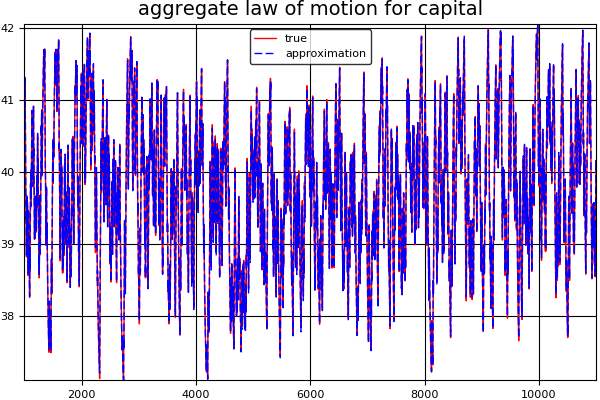

In [21]:
plot_ALM(ksp.z_grid,z_shocks,
         kss.B,K_ts)

In [22]:
#kss.B  # Regression coefficient
println("Approximated aggregate capital law of motion")
println("log(K_{t+1})=$(kss.B[1])+$(kss.B[2])log(K_{t}) in good time (R2 = $(kss.R2[1]))")
println("log(K_{t+1})=$(kss.B[3])+$(kss.B[4])log(K_{t}) in bad time (R2 = $(kss.R2[2]))")

Approximated aggregate capital law of motion
log(K_{t+1})=0.14136817405539825+0.9623027152453734log(K_{t}) in good time (R2 = 0.9999992137407112)
log(K_{t+1})=0.11653324573318116+0.9676352636916012log(K_{t}) in bad time (R2 = 0.9999982189177621)


In [23]:
save("result_VFI.jld","kss",kss)

In [24]:
# Compute mean of capital implied by regression
mc=MarkovChain(ksp.TransMat.Pz)
sd=stationary_distributions(mc)[1]
logKg=kss.B[1]/(1-kss.B[2])
logKb=kss.B[3]/(1-kss.B[4])
meanK_reg=exp(sd[1]*logKg+sd[2]*logKb)
meanK_sim=mean(K_ts[1001:end])
println("mean of capital implied by regression is $meanK_reg")
println("mean of capital implied by simulation is $meanK_sim")

mean of capital implied by regression is 39.46272307237643
mean of capital implied by simulation is 39.70193508699299


## Figures in Krusell-Smith

### Figure 1


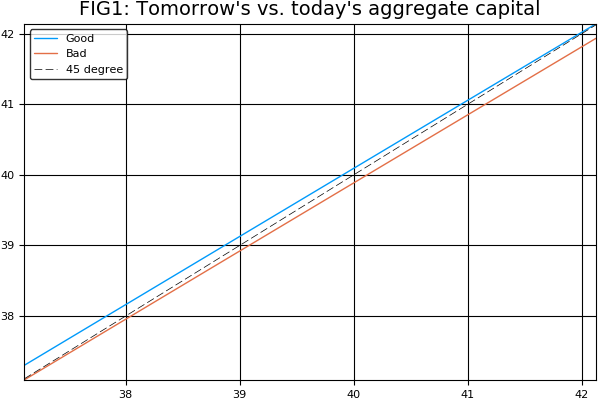

In [25]:
plot_Fig1(ksp,kss,K_ts)

### Figure 2


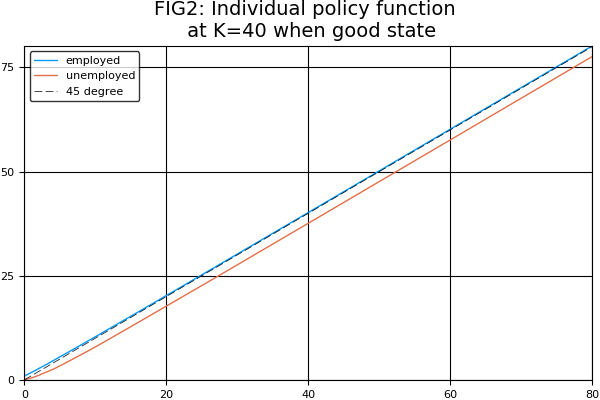

In [26]:
plot_Fig2(ksp,kss,40)

Again, the figures are succesfully replicated.